### Exploring the Dataset

##### Importing all the necessary modules and reading the data

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
# Import necessary libraries for text processing
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import FreqDist
from nltk import ngrams
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
# Import necessary libraries for dimensionality reduction
from sklearn.decomposition import PCA
import umap
# Import necessary libraries for clustering and text processing
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
# Import necessary libraries for  visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
reviews = pd.read_json('Data\Yelp-JSON\Yelp JSON\Extracted\yelp_academic_dataset_review.json', lines=True, nrows=200000)
print(reviews.shape)
reviews.head()

(200000, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


##### exploring the data and preprocessing

In [ ]:
reviews['length'] = reviews['text'].apply(lambda x: len(x.split()))

reviews['date'] = pd.to_datetime(reviews['date'])
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month 
reviews['day'] = reviews['date'].dt.day

reviews.drop(columns=['date'], inplace=True)

In [16]:
reviews.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
stars,200000.0,3.841425,1.357044,1.0,3.0,4.0,5.0,5.0
useful,200000.0,0.901890,2.062767,0.0,0.0,0.0,1.0,320.0
funny,200000.0,0.257635,1.002639,0.0,0.0,0.0,0.0,98.0
cool,200000.0,0.349225,1.077559,0.0,0.0,0.0,0.0,49.0
length,200000.0,101.296765,93.519058,1.0,41.0,73.0,129.0,1006.0
year,200000.0,2014.833300,2.439746,2005.0,2013.0,2015.0,2017.0,2019.0
month,200000.0,6.327750,3.316025,1.0,3.0,6.0,9.0,12.0
day,200000.0,15.655795,8.806177,1.0,8.0,16.0,23.0,31.0


In [17]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_id    200000 non-null  object
 1   user_id      200000 non-null  object
 2   business_id  200000 non-null  object
 3   stars        200000 non-null  int64 
 4   useful       200000 non-null  int64 
 5   funny        200000 non-null  int64 
 6   cool         200000 non-null  int64 
 7   text         200000 non-null  object
 8   length       200000 non-null  int64 
 9   year         200000 non-null  int32 
 10  month        200000 non-null  int32 
 11  day          200000 non-null  int32 
dtypes: int32(3), int64(5), object(4)
memory usage: 16.0+ MB


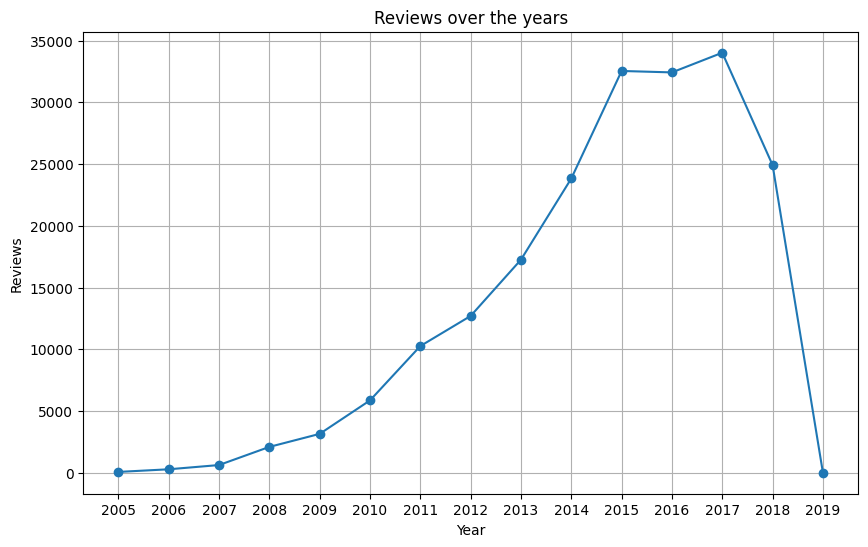

In [24]:
reviews_per_year = reviews.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.plot(reviews_per_year['year'], reviews_per_year['count'], marker='o')
plt.title('Reviews over the years')
plt.xlabel('Year')
plt.ylabel('Reviews')
plt.xticks(reviews_per_year['year'])
plt.grid()
plt.show()